In [6]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from estimation.distance_sensor import distance_sensors
from estimation.non_iterative_estimator import non_iterative_estimator
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
import random
import torch
import torch.nn as nn
import time

In [9]:
# create test data
target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1
sensor_loc = [[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]]

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)
outliers = np.random.randint(0, 100, size=len(path1.path))
outliers = outliers > (100 - 2)

# create noisy sensors
sensors = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 15)
sensors.calculate_measurements(path1.path)
non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
estimated_path = non_it_est.estimate_path()

sensors_noisy = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 200)
sensors_noisy.calculate_measurements(path1.path)
non_it_est_noisy = non_iterative_estimator(sensors_noisy, path1.path[0,:])
estimated_path_noisy = non_it_est_noisy.estimate_path()

sigma_a = 1
sigma_v = 500
kf = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
kf_path, P, X, L, delta_x = kf.filter_path(estimated_path)

sample = 1
XTest = []
n = []
for i in np.arange(len(kf_path) - sample):
    # tmp = np.concatenate((kf_path[i, :].reshape(1,-1), np.reshape(P[i, :, :], (1,-1)), X[i,:].reshape(1,-1), L[i,:], delta_x[i,:]), 1)
    # tmp = np.concatenate((L[i,:].reshape(1,-1), delta_x[i,:].reshape(1,-1)), 1)
    # tmp = np.array([7000, 5000, 3000]).reshape(1,3)
    if outliers[i+1]:
        X_n, P_n, L_n, delta_x_n = kf.kalman_step(X[i,:], P[i,:], estimated_path_noisy[i+1, :])
        tmp = np.concatenate((estimated_path_noisy[i+1, :].reshape(1,-1), np.reshape(P[i+1, :, :], (1,-1)), X[i+1,:].reshape(1,-1), L[i+1,:].reshape(1,-1), delta_x[i+1,:].reshape(1,-1), np.reshape(P_n, (1,-1)), X_n.reshape(1,-1), L_n.reshape(1,-1), delta_x_n.reshape(1,-1)), 1)
        # tmp =  np.concatenate((tmp, estimated_path_noisy[i+1, :].reshape(1,-1)),1)
    else:
        X_n, P_n, L_n, delta_x_n = kf.kalman_step(X[i,:], P[i,:], estimated_path[i+1, :])
        tmp = np.concatenate((estimated_path[i+1, :].reshape(1,-1), np.reshape(P[i+1, :, :], (1,-1)), X[i+1,:].reshape(1,-1), L[i+1,:].reshape(1,-1), delta_x[i+1,:].reshape(1,-1), np.reshape(P_n, (1,-1)), X_n.reshape(1,-1), L_n.reshape(1,-1), delta_x_n.reshape(1,-1)), 1)
        # tmp =  np.concatenate((tmp, estimated_path[i+1, :].reshape(1,-1)),1)

    # tmp = np.concatenate((tmp, outliers[i+1].reshape(1,1)), 1)

    # tmp = outliers[i+1].reshape(1,1)
    tmp = tmp.reshape(1, tmp.shape[1] ,1)
    if i > 0:
        XTest = np.concatenate((XTest, tmp), 2)
        # loc = kf.H@X_n
        n = np.concatenate((n, X_n.reshape(1,9)), 0)
    else:
        XTest = tmp
        # loc = kf.H@X_n
        n = X_n.reshape(1,9)

YTest = outliers[1:].reshape(-1,1)

print(np.shape(YTest))
print(np.shape(XTest))

(2897, 1)
(1, 207, 2897)


In [3]:
# create train data
run_number = 60
XTrain = []
YTrain = []
for k in np.arange(run_number):
    target_initial_pos = np.random.randint(-7000, 7000, size=(1, 3))[0]
    sensors_pos = np.random.randint(-7000, 7000, size=(3, 3))[:,:]
    target_speed_xy = 50
    target_speed_z = 10
    target_rot_speed = 3
    time_res = 0.1

    path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
    path1.add_straight_interval(np.random.randint(0,100,size=1)[0])
    path1.add_xy_turn_interval(np.random.randint(0,100,size=1)[0], -random.choice([-1, 1])*np.deg2rad(target_rot_speed))
    outliers = np.random.randint(0, 100, size=len(path1.path))
    outliers = outliers > (100 - 50)

    # create noisy sensors
    sensors = distance_sensors(sensors_pos, 15)
    sensors.calculate_measurements(path1.path)
    non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
    estimated_path = non_it_est.estimate_path()

    sensors_noisy = distance_sensors(sensors_pos, 200)
    sensors_noisy.calculate_measurements(path1.path)
    non_it_est_noisy = non_iterative_estimator(sensors_noisy, path1.path[0,:])
    estimated_path_noisy = non_it_est_noisy.estimate_path()

    sigma_a = 1
    sigma_v = 500
    kf = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
    kf_path, P, X, L, delta_x = kf.filter_path(estimated_path)

    sample = 1
    for i in np.arange(len(kf_path) - sample):
        # tmp = np.concatenate((kf_path[i, :].reshape(1,-1), np.reshape(P[i, :, :], (1,-1)), X[i,:].reshape(1,-1)), 1)
        # tmp = np.concatenate((L[i,:].reshape(1,-1), delta_x[i,:].reshape(1,-1)), 1)
        if outliers[i+1]:
            X_n, P_n, L_n, delta_x_n = kf.kalman_step(X[i,:], P[i,:], estimated_path_noisy[i+1, :])
            tmp = np.concatenate((estimated_path_noisy[i+1, :].reshape(1,-1), np.reshape(P[i+1, :, :], (1,-1)), X[i+1,:].reshape(1,-1), L[i+1,:].reshape(1,-1), delta_x[i+1,:].reshape(1,-1), np.reshape(P_n, (1,-1)), X_n.reshape(1,-1), L_n.reshape(1,-1), delta_x_n.reshape(1,-1)), 1)
            # tmp =  np.concatenate((tmp, estimated_path_noisy[i+1, :].reshape(1,-1)),1)
        else:
            X_n, P_n, L_n, delta_x_n = kf.kalman_step(X[i,:], P[i,:], estimated_path[i+1, :])
            tmp = np.concatenate((estimated_path[i+1, :].reshape(1,-1), np.reshape(P[i+1, :, :], (1,-1)), X[i+1,:].reshape(1,-1), L[i+1,:].reshape(1,-1), delta_x[i+1,:].reshape(1,-1), np.reshape(P_n, (1,-1)), X_n.reshape(1,-1), L_n.reshape(1,-1), delta_x_n.reshape(1,-1)), 1)
            # tmp =  np.concatenate((tmp, estimated_path[i+1, :].reshape(1,-1)),1)

        # tmp = np.concatenate((tmp, outliers[i+1].reshape(1,1)), 1)

        tmp = tmp.reshape(1, tmp.shape[1] ,1)
        if (k == 0) & (i == 0):
            XTrain = tmp
        else:
            XTrain = np.concatenate((XTrain, tmp), 2)

    if k > 0:
        YTrain = np.concatenate((YTrain, outliers[1:].reshape(-1,1)))
    else:
        YTrain = outliers[1:].reshape(-1,1)

print(np.shape(YTrain))
print(np.shape(XTrain))


(61570, 1)
(1, 207, 61570)


In [4]:
# shuffle data
ind = np.arange(len(YTest))
random.shuffle(ind)

XVal = torch.from_numpy(np.transpose(XTest[:,:,ind], (2, 0, 1)))
YVal = torch.from_numpy(YTest[ind,:])

ind = np.arange(len(YTrain))
random.shuffle(ind)

XTrain = torch.from_numpy(np.transpose(XTrain[:,:,ind], (2, 0, 1)))
YTrain = torch.from_numpy(YTrain[ind,:])

In [5]:
# create network
class state_estimat(nn.Module):
    def __init__(self, d_in, num_classes):
        # initialzing the parent object (important!)
        super(state_estimat, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            # nn.Conv1d(1, 16, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv1d(16, 32, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Linear(97, 10),
            # nn.ReLU(),
            # nn.Linear(97, 2),
            # nn.ReLU(),
            nn.Conv1d(1,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool1d(2, stride=2),
            # nn.Conv1d(16,16, kernel_size=3, padding=1),
            # nn.MaxPool1d(2, stride=2),
            # nn.ReLU(),
            nn.Flatten(),
            # nn.Linear(207, 256),
            # nn.ReLU(),
            nn.Linear(6624, num_classes))
            # nn.Softmax())

    def forward(self, x):
        #x = nn.functional.normalize(x, p=1.0, dim = 1)
        return self.pipe(x)


In [13]:
# hyper-parameters:
# num_epochs = 100
num_epochs = 150
# batch_size = 512
batch_size = 512
learning_rate = 0.001
learning_rate_drop_period = 120

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
# create model
model = state_estimat(d_in=4, num_classes=1).to(device)
print(model)
# Loss and optimizer
# criterion = torch.nn.BCELoss()
#criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_drop_period, gamma=0.1)

cpu
state_estimat(
  (pipe): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=6624, out_features=1, bias=True)
  )
)


In [1]:
# Train the model
total_step = len(YTrain)
# total_step = len(YVal)
start_time = time.time()
model = model.float()

loss_train = []
loss_val = []
loss_tmp = 0
norm = 1
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(1,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(1,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().T)
        # loss2 = torch.mean(outputs**2 - y.float().T**2)
        # loss = loss1 + loss2

        loss_tmp += loss.item()
loss_val.append(loss_tmp/len(YVal))

for epoch in range(num_epochs):
    ind = np.arange(int(total_step/batch_size))
    random.shuffle(ind)
    for i,k in enumerate(ind):
        # each i is a batch of 128 samples
        x, y = XTrain[k*batch_size:(k+1)*batch_size,:,:], YTrain[k*batch_size:(k+1)*batch_size,:]
        # x, y = XVal[k*batch_size:(k+1)*batch_size,:,:], YVal[k*batch_size:(k+1)*batch_size,:]

        x = x.to(device)
        y = y.to(device)

        # Forward pass
        # x = nn.functional.normalize(x.float(), p=1.0, dim = 1)
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(batch_size,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(batch_size,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().reshape(batch_size,1))
        # loss2 = torch.sum(abs(outputs - y.float().reshape(batch_size,1)))
        # loss = loss1 + loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())

        if (i + 1) % 5== 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs, learning rate: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, int(total_step/batch_size), loss.item(), time.time() - start_time, optimizer.param_groups[0]['lr']))

    loss_tmp = 0
    result = []
    for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().reshape(1,1))
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(1,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().reshape(1,1,1))
        # loss2 = torch.mean(outputs**2 - y.float().reshape(1,1,1)**2)
        # loss = loss1 + loss2
        
        loss_tmp += loss.item()
        result.append(outputs[0,0].item())
        # result.append(nn.Sigmoid()(outputs[0,0]).item())
    loss_val.append(loss_tmp/len(YVal))

    scheduler.step()

NameError: name 'YTrain' is not defined

(0.0, 1.0)

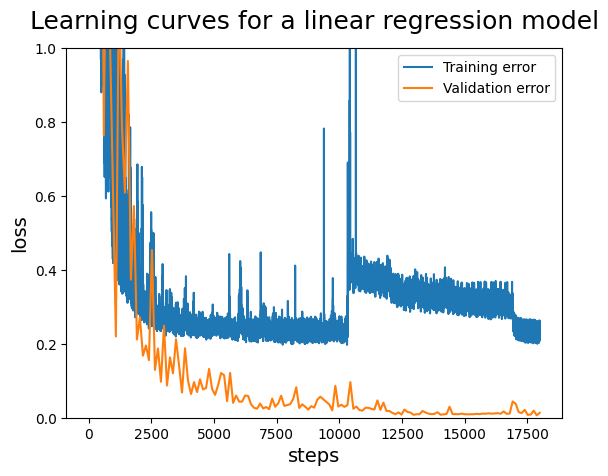

In [15]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(loss_train)), loss_train, label = 'Training error')
plt.plot(np.arange(0, len(loss_train)+1, int(total_step/batch_size)), loss_val, label = 'Validation error')
plt.ylabel('loss', fontsize = 14)
plt.xlabel('steps', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim([0,1])

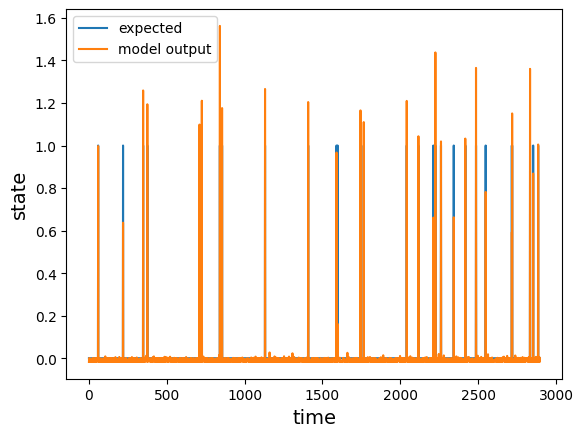

In [16]:
# plt.style.use('seaborn')
plt.plot(np.arange(len(result)), YVal, label = 'expected')
plt.plot(np.arange(len(result)), result, label = 'model output')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()
# plt.ylim([100,120])

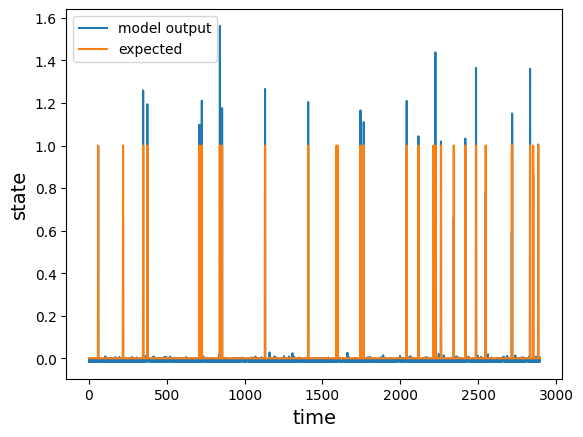

In [17]:
plt.plot(np.arange(len(result)), result, label = 'model output')
plt.plot(np.arange(len(result)), YVal, label = 'expected')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()

In [18]:
result1 = np.array(result) > 0.3
YVal1 = np.array(YVal).T
diff = np.array((result1==True) & (YVal1==True))
print(np.sum(diff.astype(int)))
print(np.sum(np.array(YVal).T.astype(int)))
print(np.sum(result1))
print(100*np.sum(diff.astype(int))/np.sum(np.array(YVal).T.astype(int)))

28
29
28
96.55172413793103


ValueError: x and y must have same first dimension, but have shapes (2897,) and (1298,)

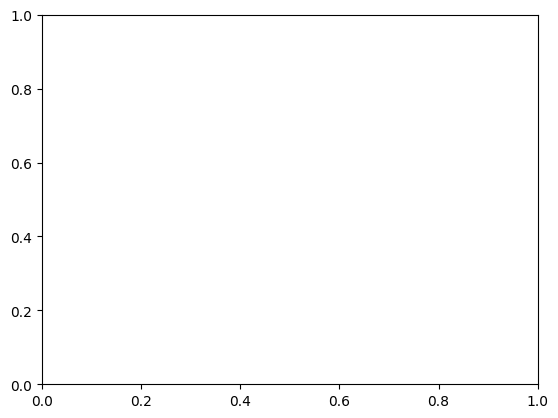

In [12]:
plt.plot(np.arange(len(YTest)), 50*outliers[1:], label = 'model output')
plt.plot(np.arange(len(YTest)), np.max(abs(X[1:,:]-n), axis=1), label = 'model output')
# plt.plot(np.arange(len(YTest)+1), L[:,3], label = 'expected')
# plt.plot(np.arange(len(YTest)+1), L[:,6], label = 'expected')

plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()
plt.figure(figsize=(5,5))
# plt.ylim([0,1])

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(path1.path[:,0], path1.path[:,1], path1.path[:,2], label = 'model output')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()

In [21]:
path = "best_state_dict.pt"
torch.save(model.state_dict(), path)

In [22]:
model2 = state_estimat(d_in=4, num_classes=1)
model2.load_state_dict(torch.load(path))
model2.eval()

state_estimat(
  (pipe): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=6624, out_features=1, bias=True)
  )
)

In [23]:
path2 = "best_model.pt"
torch.save(model, path2)

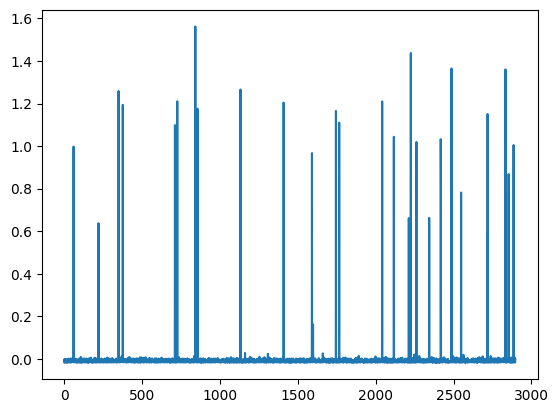

In [26]:
result2 = []
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:], YVal[i,:]

        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        # Forward pass val
        outputs = model2(x.float())
        # loss = criterion(nn.Sigmoid()(norm*outputs), norm*y.float().reshape(1,1,1))
        # loss1 = criterion(norm*outputs, norm*y.float().reshape(1,1,1))
        # loss2 = torch.mean(outputs**2 - y.float().reshape(1,1,1)**2)
        # loss = loss1 + loss2
        
        result2.append(outputs[0,0].item())
        
plt.plot(np.arange(len(result)), result, label = 'model output')